 This notebook is designed to facilitate the training and evaluation of a Vision Transformer (ViT) model for binary classification tasks using MIBI (Multiplexed Imaging) datasets.
 
The main functions of this notebook include:
 
1. **CUDA Availability Check**: The notebook checks if a CUDA-enabled GPU is available for training, which can significantly speed up the training process.

2. **Data Loading**: It utilizes the `MibiDataset` class to load training, validation, and testing datasets from specified HDF5 files. Data loaders are created for each dataset to facilitate batch processing during training.
 
3. **Model Training**: The notebook is set up to train a GCNN model using the `train_model` function from the `model_utils` module. This function handles the training loop, loss calculation, and optimization.

4. **Model Evaluation**: After training, the model can be evaluated on the validation and test datasets to assess its performance using various metrics.
 

In [1]:
import torch
import os,sys
import polars as pl
import mlflow
import pickle
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

notebook_path=os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_path,'NN_Framework')))
from NN_Framework import graph_model_train
from NN_Framework.mibi_dataset import MibiDataset
from NN_Framework.models import GraphConvClassifier
from NN_Framework.mibi_data_prep_graph import remapping, create_graph_patches, remapping_simplified
from NN_Framework.models.multichannel_transforms import *


In [2]:

# Check if CUDA is available
print("Is CUDA available:", torch.cuda.is_available())

print("Number of GPUs available:", torch.cuda.device_count())


if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
print("PyTorch built with CUDA Version:", torch.version.cuda)


Is CUDA available: True
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 4090 Laptop GPU
PyTorch built with CUDA Version: 11.8


In [3]:
expression_types = ['MelanA', 'Ki67', 'SOX10', 'COL1A1', 'SMA', 
                   'CD206', 'CD8', 'CD4', 'CD45', 'CD3', 'CD20', 'CD11c']
#expression_types = ['MelanA', 'CD4', 'CD45']


In [4]:
def filter_df(full_df, sub_df, expression_types,binarize=False,cell_type_col='pred',
                fov_col='fov',groups='Group', x_pos='centroid-0', y_pos='centroid-1'):
    
    fovs = full_df.filter(pl.col(fov_col).is_in(sub_df[fov_col]))
    fovs = fovs.filter(~pl.col(cell_type_col).is_in(['Unidentified', 'Immune']))  # Remove confounding cells

    columns_to_keep = [cell_type_col, fov_col, groups,x_pos,y_pos] + expression_types
    fovs = fovs.select(columns_to_keep)

    fovs = remapping_simplified(df=fovs, column_name=cell_type_col)  # Remap larger cell name list to smaller one
    return fovs
    

In [5]:
def compute_global_stats(fovs,expression_types):
    result = fovs.select([
                        *(pl.col(col).mean().alias(f"{col}_mean") for col in expression_types if col not in ["remapped"]),
                        *(pl.col(col).std().alias(f"{col}_std") for col in expression_types if col not in ["remapped"]),
                        *(pl.col(col).min().alias(f"{col}_min") for col in expression_types if col not in ["remapped"]),
                        *(pl.col(col).max().alias(f"{col}_max") for col in expression_types if col not in ["remapped"]),
                        ])
    return result

In [6]:
def compute_grouped_stats(fovs,expression_types):
    result = (fovs.group_by("remapped").agg([
                        *(pl.col(col).mean().alias(f"{col}_mean") for col in expression_types if col not in ["remapped"]),
                        *(pl.col(col).std().alias(f"{col}_std") for col in expression_types if col not in ["remapped"]),
                        *(pl.col(col).min().alias(f"{col}_min") for col in expression_types if col not in ["remapped"]),
                        *(pl.col(col).max().alias(f"{col}_max") for col in expression_types if col not in ["remapped"]),]))
    return result

In [7]:
def min_max_rescaling(fovs, global_stats, expression_types):
    nu_expressions=[]
    for col in expression_types:
        try:
            
            min_val = global_stats.select(pl.col(f"{col}_min")).item()
            max_val = global_stats.select(pl.col(f"{col}_max")).item()

            if min_val is None or max_val is None:
                raise ValueError(f"Missing value for min or max in column '{col}'")

            fovs = fovs.with_columns(
                ((pl.col(col) - min_val) / (max_val - min_val)).alias(f"{col}_minmaxed")
            )
            nu_expressions.append(f"{col}_minmaxed")
        except Exception as e:
            raise ValueError(f"Error in rescaling column '{col}': {e}")
    
    return fovs,nu_expressions

In [8]:
def full_pipe(full_df, sub_df, expression_types,normalize_stats=None, binarize=True, cell_type_col='pred',fov_col='fov',groups='Group', x_pos='centroid-0', y_pos='centroid-1',radius=25,stride=248):
    

    fovs=filter_df(full_df, sub_df, expression_types=expression_types,binarize=binarize,cell_type_col=cell_type_col,
                fov_col=fov_col,groups=groups, x_pos=x_pos, y_pos=y_pos)
    

    if normalize_stats is not None and normalize_stats.is_empty():
        fovs,nu_expression=min_max_rescaling(fovs=fovs, global_stats=normalize_stats, expression_types=expression_types)
    else:
        normalize_stats=compute_global_stats(fovs,expression_types)
        fovs,nu_expressions=min_max_rescaling(fovs=fovs, global_stats=normalize_stats, expression_types=expression_types)

    
    graphs,fov_list = create_graph_patches(df=fovs, expressions=nu_expressions,
                        stride=stride,binarize=binarize,group_col=groups,
                        cell_type_col='remapped',radius=radius)#Note remapped is used and hard coded
    
    assert graphs is not None, "Error: Graphs is None."
    assert fov_list is not None, "Error: fov_list is None."
    print("Graphs and fov_list have been successfully created.")
    return graphs,fov_list,normalize_stats

In [9]:


full_df = pl.read_csv(r"D:\MIBI-TOFF\Data_For_Amos\cleaned_expression_with_both_classification_prob_spatial_30_08_24.csv")

with open(r'D:\MIBI-TOFF\Mibi-Analysis-py\data_split_train100_val58_test19.pkl', 'rb') as pickle_file:
    data_loaded = pickle.load(pickle_file)

train_data = pl.DataFrame(data_loaded['train_data'])
val_data = pl.DataFrame(data_loaded['val_data'])
test_data = pl.DataFrame(data_loaded['test_data'])


#hard coded the minimum cell count but that could be an additional input. 
train_graphs,train_fovs,normalization_stats=full_pipe(full_df=full_df, sub_df=train_data, 
                            expression_types=expression_types,normalize_stats=None, binarize=True,
                            cell_type_col='pred',fov_col='fov' ,radius=25,stride=512)
torch.save((train_graphs, train_fovs), r"D:\MIBI-TOFF\Scratch\train_full_r25_graphs.pt")

val_graphs,val_fovs,_=full_pipe(full_df=full_df, sub_df=val_data, 
                        expression_types=expression_types,normalize_stats=normalization_stats,binarize=True, 
                        cell_type_col='pred',fov_col='fov' ,radius=25,stride=512)
torch.save((val_graphs,val_fovs), r"D:\MIBI-TOFF\Scratch\val_full_r25_graphs.pt")

test_graphs,test_fovs,_=full_pipe(full_df=full_df, sub_df=test_data, 
                        expression_types=expression_types,normalize_stats=normalization_stats,
                        binarize=True, cell_type_col='pred',fov_col='fov' ,radius=25,stride=512)
torch.save((test_graphs,test_fovs), r"D:\MIBI-TOFF\Scratch\test_full_r25_graphs.pt")



Graphs and fov_list have been successfully created.
Graphs and fov_list have been successfully created.
Graphs and fov_list have been successfully created.


In [10]:
train_graphs,fov_test =torch.load( r"D:\MIBI-TOFF\Scratch\train_full_r25_graphs.pt")
val_graphs,_ = torch.load( r"D:\MIBI-TOFF\Scratch\val_full_r25_graphs.pt")
test_graphs,_ = torch.load( r"D:\MIBI-TOFF\Scratch\test_full_r25_graphs.pt")

print(fov_test)

train_loader = DataLoader(train_graphs, batch_size=100, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=100, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=100, shuffle=True)
del train_graphs, val_graphs, test_graphs

C:\Users\chirr\AppData\Local\Temp\ipykernel_63608\3635928632.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_graphs,fov_test =torch.load( r"D:\MIBI-TOFF\Scratch\tr

['FOV108', 'FOV286', 'FOV2', 'FOV248', 'FOV296', 'FOV62', 'FOV80', 'FOV298', 'FOV342', 'FOV404', 'FOV148', 'FOV110', 'FOV232', 'FOV8', 'FOV36', 'FOV176', 'FOV90', 'FOV268', 'FOV22', 'FOV252', 'FOV6', 'FOV102', 'FOV412', 'FOV86', 'FOV424', 'FOV240', 'FOV44', 'FOV306', 'FOV270', 'FOV116', 'FOV428', 'FOV76', 'FOV284', 'FOV64', 'FOV66', 'FOV114', 'FOV52', 'FOV288', 'FOV112', 'FOV34', 'FOV132', 'FOV82', 'FOV42', 'FOV152', 'FOV88', 'FOV172', 'FOV422', 'FOV144', 'FOV304', 'FOV184', 'FOV134', 'FOV426', 'FOV96', 'FOV104', 'FOV250', 'FOV222', 'FOV366', 'FOV390', 'FOV190', 'FOV302', 'FOV294', 'FOV362', 'FOV68', 'FOV154', 'FOV4', 'FOV300', 'FOV402', 'FOV140', 'FOV418', 'FOV136', 'FOV94', 'FOV124', 'FOV420', 'FOV10', 'FOV142', 'FOV368', 'FOV98', 'FOV126', 'FOV308', 'FOV50', 'FOV118', 'FOV138', 'FOV106', 'FOV400', 'FOV150', 'FOV84', 'FOV364', 'FOV24', 'FOV78', 'FOV178', 'FOV234', 'FOV224', 'FOV12', 'FOV92', 'FOV74', 'FOV392', 'FOV146', 'FOV226', 'FOV72', 'FOV70']


C:\Users\chirr\AppData\Local\Temp\ipykernel_63608\3635928632.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_graphs,_ = torch.load( r"D:\MIBI-TOFF\Scratch\test_full

In [11]:
#Check Feature Dims Training
for i, data in enumerate(val_loader.dataset):
    print(f"Graph {i}:")
    print(f"  Node feature shape: {data.x.shape}")
    print(f"  Edge index shape: {data.edge_index.shape}")
    if data.edge_attr is not None:
        print(f"  Edge attribute shape: {data.edge_attr.shape}")


#test_patch_size smaller  despite equal samples   
    

Graph 0:
  Node feature shape: torch.Size([533, 16])
  Edge index shape: torch.Size([2, 1856])
Graph 1:
  Node feature shape: torch.Size([614, 16])
  Edge index shape: torch.Size([2, 2418])
Graph 2:
  Node feature shape: torch.Size([703, 16])
  Edge index shape: torch.Size([2, 3212])
Graph 3:
  Node feature shape: torch.Size([687, 16])
  Edge index shape: torch.Size([2, 3074])
Graph 4:
  Node feature shape: torch.Size([600, 16])
  Edge index shape: torch.Size([2, 2340])
Graph 5:
  Node feature shape: torch.Size([745, 16])
  Edge index shape: torch.Size([2, 3692])
Graph 6:
  Node feature shape: torch.Size([801, 16])
  Edge index shape: torch.Size([2, 4138])
Graph 7:
  Node feature shape: torch.Size([765, 16])
  Edge index shape: torch.Size([2, 3830])
Graph 8:
  Node feature shape: torch.Size([740, 16])
  Edge index shape: torch.Size([2, 3712])
Graph 9:
  Node feature shape: torch.Size([856, 16])
  Edge index shape: torch.Size([2, 4774])
Graph 10:
  Node feature shape: torch.Size([850, 1

In [12]:
x_shapes_row_dims = {
    'train':[],
    'val':[],
    'test':[],
    }
edge_index_row_dims = {
    'train':[],
    'val':[],
    'test':[],
    }

for i, data in enumerate(train_loader.dataset):
    x_shapes_row_dims['train'].append(data.x.shape[0])  
    edge_index_row_dims['train'].append(data.edge_index.shape[1]) 

for i, data in enumerate(val_loader.dataset):
    x_shapes_row_dims['val'].append(data.x.shape[0])  
    edge_index_row_dims['val'].append(data.edge_index.shape[1]) 

for i, data in enumerate(test_loader.dataset):
    x_shapes_row_dims['test'].append(data.x.shape[0])  
    edge_index_row_dims['test'].append(data.edge_index.shape[1]) 

print(x_shapes_row_dims)
print(edge_index_row_dims)

{'train': [687, 735, 509, 703, 535, 530, 610, 565, 541, 638, 556, 632, 576, 634, 621, 596, 473, 712, 774, 651, 465, 451, 547, 602, 483, 467, 440, 562, 588, 551, 705, 592, 554, 717, 801, 574, 612, 792, 811, 839, 607, 843, 837, 880, 679, 766, 865, 848, 698, 666, 765, 756, 324, 127, 291, 444, 354, 372, 272, 437, 508, 565, 509, 502, 536, 604, 676, 646, 449, 653, 701, 690, 508, 738, 872, 749, 198, 601, 793, 672, 68, 344, 594, 385, 609, 733, 765, 749, 589, 758, 844, 838, 584, 608, 816, 872, 475, 600, 766, 810, 560, 533, 700, 620, 608, 316, 347, 295, 681, 535, 391, 570, 708, 770, 781, 872, 673, 668, 444, 643, 437, 489, 690, 477, 499, 688, 811, 564, 228, 261, 258, 239, 794, 855, 797, 815, 770, 895, 932, 830, 743, 900, 923, 788, 742, 785, 813, 702, 541, 706, 809, 933, 596, 776, 772, 950, 603, 909, 863, 719, 839, 842, 920, 830, 679, 647, 746, 806, 713, 876, 882, 844, 737, 858, 811, 763, 674, 835, 811, 711, 223, 325, 535, 532, 290, 249, 207, 197, 201, 191, 195, 217, 204, 227, 172, 196, 173, 193, 

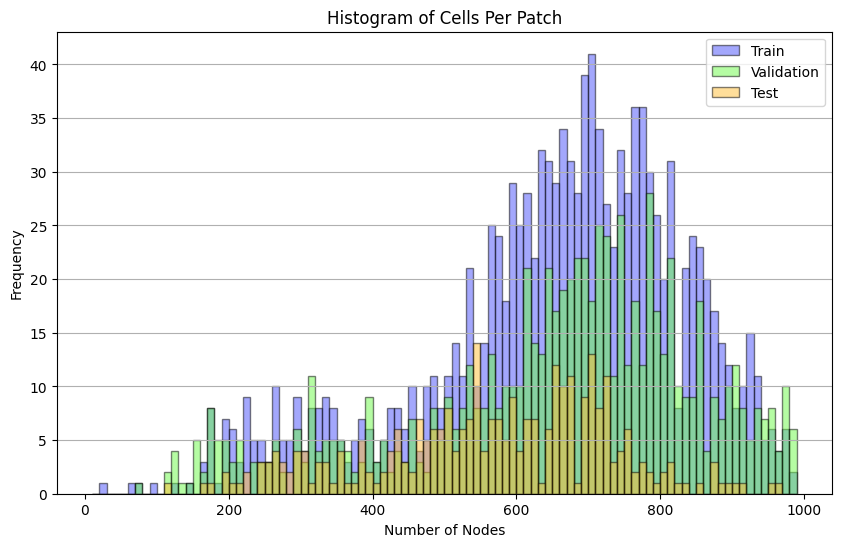

In [13]:
import matplotlib.pyplot as plt

bins=range(10,1000,10)
colors = {
    'train': '#4851fb',
    'val': '#6dfb48',
    'test': '#ffbe36' 
}


plt.figure(figsize=(10, 6))
plt.hist(x_shapes_row_dims['train'], bins=bins, alpha=0.5, label='Train', edgecolor='black', color=colors['train'])
plt.hist(x_shapes_row_dims['val'], bins=bins, alpha=0.5, label='Validation', edgecolor='black', color=colors['val'])
plt.hist(x_shapes_row_dims['test'], bins=bins, alpha=0.5, label='Test', edgecolor='black', color=colors['test'])
plt.title('Histogram of Cells Per Patch')
plt.xlabel('Number of Nodes')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.legend()  # Add legend to the plot
plt.show()


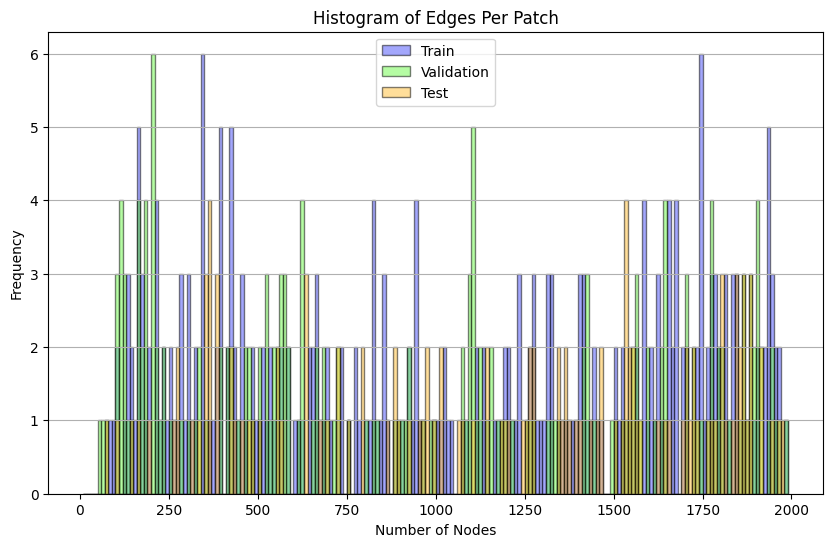

In [14]:
import matplotlib.pyplot as plt

bins=range(10,2000,10)
colors = {
    'train': '#4851fb',
    'val': '#6dfb48',
    'test': '#ffbe36' 
}


plt.figure(figsize=(10, 6))
plt.hist(edge_index_row_dims['train'], bins=bins, alpha=0.5, label='Train', edgecolor='black', color=colors['train'])
plt.hist(edge_index_row_dims['val'], bins=bins, alpha=0.5, label='Validation', edgecolor='black', color=colors['val'])
plt.hist(edge_index_row_dims['test'], bins=bins, alpha=0.5, label='Test', edgecolor='black', color=colors['test'])
plt.title('Histogram of Edges Per Patch')
plt.xlabel('Number of Nodes')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.legend() 
plt.show()

In [15]:
model_name='512p_GCN_12_channel'

# Model selection based on name
if any(x in model_name.lower() for x in ['gcn']):
    print('GCN')
    model = GraphConvClassifier(input_dim=len(expression_types)+4, hidden_dim=128, num_classes=2)
    
else:
    raise ValueError(f"Model type not recognized in model name: {model_name}")




criterion = torch.nn.CrossEntropyLoss()  # Define the classification criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4,weight_decay=1e-5)  # Define the optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Set device to GPU (0)
model.to(device)
criterion = criterion.to(device)
print(torch.cuda.is_available(),device)
print(next(model.parameters()).device) 

GCN
True cuda:0
cuda:0


Ending MLFlow if an issue causes it to not close correctly. 

In [16]:
mlflow.end_run()


In [21]:
#Parameter Block
params_block={'location':r'D:\MIBI-TOFF\Scratch\DL_Results',
'epochs':20000,
'patience':20000,
'delta':0.00000001,
'check_val_freq':5,
'num_classes':2,
'model_name':model_name,
'log_with_mlflow':True,
'mlflow_uri':"http://127.0.0.1:5000"}

In [22]:
batch = next(iter(train_loader))
print("Batch node features shape:", batch.x.shape)
print("Batch edge index shape:", batch.edge_index.shape)
if batch.edge_attr is not None:
    print("Batch edge attributes shape:", batch.edge_attr.shape)

Batch node features shape: torch.Size([68444, 16])
Batch edge index shape: torch.Size([2, 325982])


Comments from the BOSS- Markov Clustering on the cell types. broad clusters based on the cell types.

get Suggestions on norm strats

In [23]:
graph_model_train.train_model(model, train_loader, val_loader, criterion, optimizer, device, location=params_block['location'], 
    epochs=params_block['epochs'], patience=params_block['patience'], delta=params_block['delta'], check_val_freq=params_block['check_val_freq'],
    num_classes=params_block['num_classes'], model_name=params_block['model_name'], log_with_mlflow=params_block['log_with_mlflow'], mlflow_uri=params_block['mlflow_uri'])

Started MLflow run with ID: fede74fce3204b4185d481e8b1ab629e
Epoch 1, Train Loss: 0.2222,  Acc: 91.77%,  F1: 90.86251068115234,  Precision: 92.52,  Recall: 89.26
Epoch 2, Train Loss: 0.2134,  Acc: 92.15%,  F1: 91.25214385986328,  Precision: 93.33,  Recall: 89.26
Epoch 3, Train Loss: 0.2284,  Acc: 90.54%,  F1: 89.47818756103516,  Precision: 91.27,  Recall: 87.75
Epoch 4, Train Loss: 0.2157,  Acc: 92.00%,  F1: 91.15646362304688,  Precision: 92.41,  Recall: 89.93
Epoch 5, Train Loss: 0.2262,  Acc: 91.00%,  F1: 90.02557373046875,  Precision: 91.51,  Recall: 88.59
Epoch 5, Val Loss: 1.6555, Val Acc: 51.61%, Val F1: 62.00194549560547, Val Precision: 74.36, Val Recall: 53.17
Average Prediction Confidence: 0.8315
Class-wise Metrics: 
Model saved with improved validation loss: 1.6555
Epoch 6, Train Loss: 0.2209,  Acc: 91.15%,  F1: 90.17933654785156,  Precision: 91.83,  Recall: 88.59
Epoch 7, Train Loss: 0.2187,  Acc: 91.31%,  F1: 90.36658477783203,  Precision: 91.85,  Recall: 88.93
Epoch 8, Tra

KeyboardInterrupt: 

In [20]:
model.load_state_dict(torch.load(os.path.join(params_block['location'], f"{params_block['model_name']}best_model.pth")))

avg_test_loss, test_metrics = graph_model_train.eval_model(model, test_loader, criterion, device, params_block['num_classes'], epoch=0)


print(f"Test Loss: {avg_test_loss:.4f}")
for metric_name, metric_value in test_metrics.items():
    print(metric_name,metric_value)
    #print(f"{metric_name}: {metric_value:.4f}")


C:\Users\chirr\AppData\Local\Temp\ipykernel_63608\2495954858.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(params_block['

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\MIBI-TOFF\\Scratch\\DL_Results\\512p_GCN_12_channelbest_model.pth'

In [ ]:
# Evaluate the model using the eval_model function
avg_val_loss, val_metrics = graph_model_train.eval_model(model, val_loader, criterion, device, params_block['num_classes'], epoch=0)

# Print all the metrics
print(f"Test Loss: {avg_val_loss:.4f}")
for metric_val_name, metric_val_value in val_metrics.items():
    print(metric_name,metric_value)
    #print(f"{metric_name}: {metric_value:.4f}")

In [ ]:
print(test_loader)
print(val_loader)
# Compare the contents of the two loaders
test_data = [data for data, _ in test_loader]
val_data = [data for data, _ in val_loader]

# Check if the lengths of the datasets are the same
if len(test_data) == len(val_data):
    print("The test and validation loaders have the same number of batches.")
else:
    print(f"The test loader has {len(test_data)} batches, while the validation loader has {len(val_data)} batches.")

# Compare the contents of the first batch in both loaders
if test_data and val_data:
    print("Comparing the first batch of test and validation loaders:")
    print("Test batch:", test_data[0])
    print("Validation batch:", val_data[0])
else:
    print("One of the loaders is empty.")
